## Analyses of Prediction Results

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import json
import seaborn as sns
from tools import save_hdf, cbarpam
init_notebook_mode(connected=True)
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Load FEWSNET admin boundaries of Somalia (1990)
adm1_1990 = gpd.read_file('./data/shapefile/SO_Admin1_1990.shp')           # Total 18 FNID
adm2_1990 = gpd.read_file('./data/shapefile/SO_Admin2_1990_revised.shp')   # Total 74 FNID
joint = dict(adm2_1990[['FNID','FNID_ADM1']].values)
shape1 = adm1_1990.drop(adm1_1990.columns[1:13], axis=1)
shape2 = adm2_1990.drop(adm2_1990.columns[2:14], axis=1).rename({'FNID':'FNID_ADM2'}, axis=1)
lims = [40.95, 51.42, -1.67, 11.99]  # [minx,maxx,miny,maxy]

In [2]:
# Load data
crop = pd.read_hdf('./data/crop/SO_admin2_maize_yield.hdf')
dist = crop.columns; dist.name = 'FNID_ADM2'
msess = pd.read_hdf('./data/result/admin2_msess.hdf').reset_index()
gss = pd.read_hdf('./data/result/admin2_gss.hdf').reset_index()
mapdata2 = shape2.merge(msess, on='FNID_ADM2').merge(gss, on='FNID_ADM2')
# Short-records
alive = msess.loc[msess.isna().sum(1) == 0, 'FNID_ADM2'].values
short = shape2[~np.isin(shape2['FNID_ADM2'], alive)]

./figures/SO_maize_yield_sscores.png is saved.


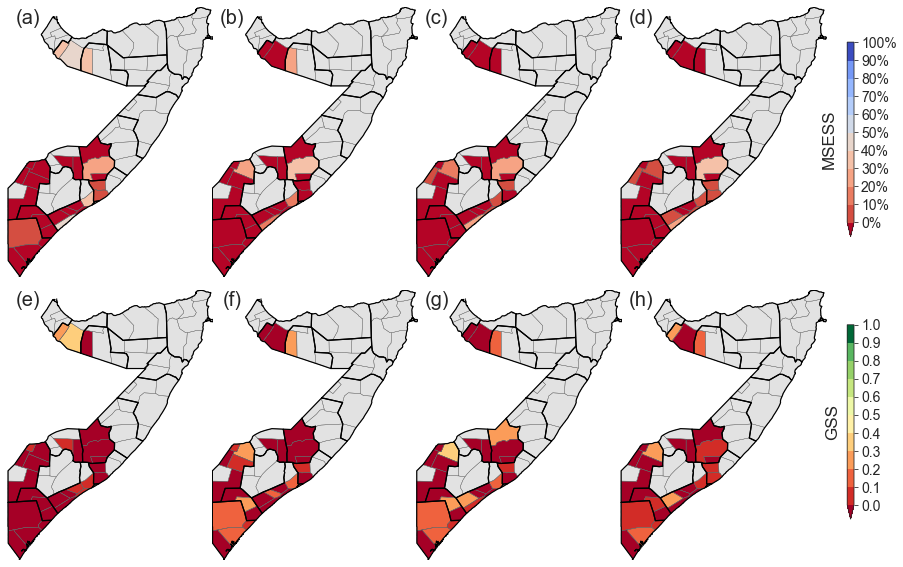

In [3]:
# Colormap
bounds1 = list(np.arange(0,101,10))
boundaries1 = [-1000000]+bounds1
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'coolwarm_r', labloc='on', 
                                                          boundaries=boundaries1, extension='min')
bounds2 = list(np.arange(0,1.1,0.1))
boundaries2 = [-1000]+bounds2
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'RdYlGn', labloc='on', 
                                                          boundaries=boundaries2, extension='min')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)', '(d)','(e)','(f)','(g)','(h)']
figlabel = ['MSESS','GSS']
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(14,8), facecolor='w')
ssname = [*msess.columns[1:].to_list(), *gss.columns[1:].to_list()]
for (i, el) in enumerate(ssname):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    if el.startswith('mse'):
        cmap, norm, vmin, vmax = cmap1, norm1, vmin1, vmax1
    else:
        cmap, norm, vmin, vmax = cmap2, norm2, vmin2, vmax2
    # Plot
    mapdata2.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
    short.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
    shape2.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='#525252')
    ax.annotate(fignumb[i], xy=(0.1, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='k')
plt.tight_layout(w_pad=-15)

# Colorbars
for i in [3,7]:
    ax = ax = axes.flatten('C')[i]
    cax = inset_axes(ax, width="3%", height="60%",
                     loc='lower left',
                     bbox_to_anchor=(1.1, 0.15, 1.1, 1.2),
                     bbox_transform=ax.transAxes,borderpad=0)
    if i == 3:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='vertical')
        cbar.ax.set_yticklabels(['%.f%%'%lb for lb in np.array(bounds1)], fontname='arial', fontsize=14)
        label = figlabel[0]
        lpad=-75
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='vertical')
        cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds2)], fontname='arial', fontsize=14)
        label = figlabel[1]
        lpad=-55
    cbar.set_label(label, labelpad=lpad, 
                   fontname='arial', fontsize=17, 
                   horizontalalignment='center')

# # Colorbar for the unreported districts
# cax2 = inset_axes(ax, width="46%", height="3.5%", bbox_to_anchor=(0.46, -0.74, 0.2, 0.8),bbox_transform=ax.transAxes,borderpad=0)
# cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=ListedColormap('#E2E2E2'),ticks=[], orientation='horizontal')
# cbar2.ax.text(1.2,0,'Unreported',fontname='arial', fontsize=16)
# plt.show()

# Save a figure
if True:
    fn_save = './figures/SO_maize_yield_sscores.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

In [6]:
shape2.shape

(74, 3)